In [1]:
import sys
sys.path.append('../../')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
from tqdm import tqdm
from scipy import stats

from BayesNewton import bayesnewton
import objax

from sklearn.linear_model import LinearRegression

from rtgp.rtgp import RobustNormalGP
from rtgp.weight_functions import IMQ, partial_IMQ

import time

plt.rc('font', family='serif', size=14)

In [2]:
data = pd.read_csv("../datasets/kaggle_HFT_index_futures.csv")
obs = data["last_price"].to_numpy()
obs_grid = np.arange(0, len(obs)) * 0.001 * 500

max_idx = 46800
center_idx = 2868
"""outliers_idx = [center_idx + i for i in range(-4, 5, 1)]

for i, drop in zip(outliers_idx, [0.9995, 0.9994, 0.9992, 0.996, 0.994, 0.998, 0.998, 0.9998]):
    obs[i] = obs[i]*drop
"""

mean = obs[:max_idx].mean()
obs_std = obs[:max_idx].std()
obs = (obs[:max_idx] - mean)/obs_std
obs_grid = obs_grid[:max_idx]

print("Dataset Size : {}".format(len(obs)))


Dataset Size : 46800


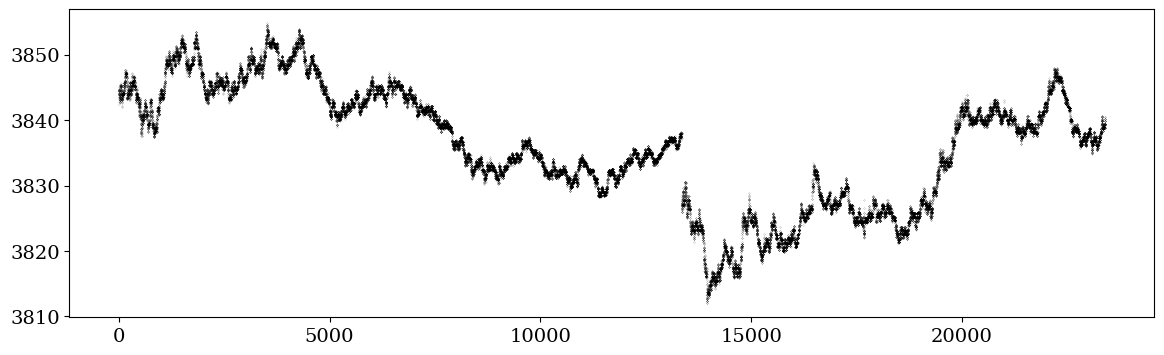

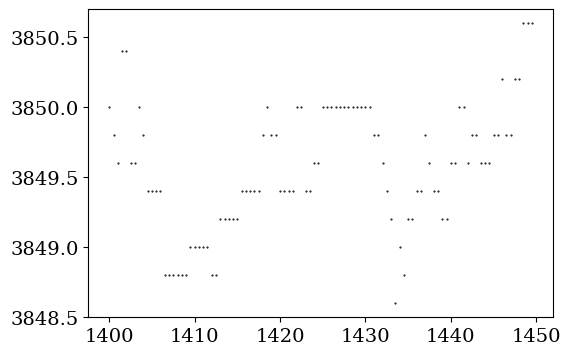

In [3]:
plt.figure(figsize=(14,4))
#plt.plot(obs_grid[outliers_idx], obs[outliers_idx] * obs_std + mean, '.',  color='red', markersize=5.)
plt.plot(obs_grid, obs * obs_std + mean, '.', color='black', markersize=0.2)

plt.figure(figsize=(6,4))
#plt.plot(obs_grid[outliers_idx], obs[outliers_idx] * obs_std + mean, '.',  color='red', markersize=10.)
plt.plot(obs_grid[2800:2900], obs[2800:2900] * obs_std + mean, '.', color='black', markersize=1)

In [106]:
def neg_log_likelihood(Y, pred, var):
    z = (Y - pred) / np.sqrt(var)
    print("Student-t", np.nanmean(stats.t.logpdf(z, df=1)))
    print("Normal", np.nanmean(stats.norm.logpdf(z)))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mae(predictions, targets):
    return np.abs(predictions - targets).mean()

In [179]:
def rtgp(obs_grid, obs, return_output=True, train=False):

    beta=1.
    c=0.16
    #trainable parameters
    dist_params = {"loc": 0.0, "scale": 0.14}
    magnitude=6.
    lengthscale=6.

    #non-trainable parameters
    beta=beta
    c=c

    w_r = lambda y, m : IMQ(y, m, beta=beta, c=c)
    partial_w_r = lambda y, m : partial_IMQ(y=y, m=m, beta=beta, c=c)

    norm = RobustNormalGP(dist_params=dist_params, magnitude=magnitude, lengthscale=lengthscale, p=3, n=1, w_r=w_r, partial_w_r=partial_w_r)
    
    if train:
        print("Initial Parameters : ", norm.get_params())

        
        bounds = [(0, 0), (0.1, 0.6), (0.1, 2.), (0.01, 0.2)]
        norm.hyperparam_optim(obs=obs, obs_grid=obs_grid, bounds=bounds)
        
        print("Final Parameters : ", norm.get_params())

    """t1 = time.time()
    filter_grid, m, P, log_evidence = norm.fit(obs_grid=obs_grid, obs=obs, subdiv=1, truncate=False, verbose=True, return_filter_estimate=False, compute_log_evidence=True)
    t2 = time.time()"""

    t1 = time.time()
    filter_grid, m, P = norm.fit(obs_grid=obs_grid, obs=obs, subdiv=1, truncate=False, verbose=False, return_filter_estimate=False, compute_log_evidence=False)
    t2 = time.time()

    if return_output: print("Prediction time : ", t2 - t1)
        
    if return_output:
        return filter_grid, m, P
    else:
        return t2 - t1

#filter_grid, m_rtgp, P_rtgp = rtgp(obs_grid, obs)

In [6]:
rtgp_times=[8.46, 9.53, 9.89, 8.58, 7.55]
np.mean(rtgp_times), np.std(rtgp_times)

(8.802, 0.8303589585233605)

In [150]:
def std_gp(obs_grid, obs, return_output=True, train=False):

    #trainable parameters
    dist_params = {"loc": 0.0, "scale": 0.15}
    magnitude=6.
    lengthscale=6.5


    w_r = lambda y, m : 1.0
    partial_w_r = lambda y, m : 0.0

    norm = RobustNormalGP(dist_params=dist_params, magnitude=magnitude, lengthscale=lengthscale, p=3, n=1, w_r=w_r, partial_w_r=partial_w_r)
    
    if train:
        print("Initial Parameters : ", norm.get_params())

        
        bounds = [(0, 0), (0.1, 0.6), (0.1, 2.), (0.01, 0.2)]
        norm.hyperparam_optim(obs=obs, obs_grid=obs_grid, bounds=bounds)
        
        print("Final Parameters : ", norm.get_params())

    """t1 = time.time()
    filter_grid, m, P, log_evidence = norm.fit(obs_grid=obs_grid, obs=obs, subdiv=1, truncate=False, verbose=True, return_filter_estimate=False, compute_log_evidence=True)
    t2 = time.time()"""

    t1 = time.time()
    filter_grid, m, P = norm.fit(obs_grid=obs_grid, obs=obs, subdiv=1, truncate=False, verbose=False, return_filter_estimate=False, compute_log_evidence=False)
    t2 = time.time()

    if return_output: print("Prediction time : ", t2 - t1)
        
    if return_output:
        return filter_grid, m, P
    else:
        return t2 - t1

In [151]:
def bayes_newton_EP(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    gauss_lik = bayesnewton.likelihoods.Gaussian(variance=var_y)
    lik = bayesnewton.likelihoods.StudentsT(df=6)
    model = bayesnewton.models.MarkovExpectationPropagationGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output:print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output: print("Negative Log Predictive Density: ")
    if return_output: print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


    if return_output: print("Prediction time (s) : ", t2 - t1)
    if return_output:print("Lengthscale : ", model.kernel.lengthscale)
    if return_output:print("Kernel Variance : ", model.kernel.variance)
    #print("Likelihood Variance : ", model.likelihood.variance)

    if return_output:
        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model
    else:
        return t2 - t1

In [152]:
EP_times = [28.12, 26.4, 25.94, 26.51]
np.mean(EP_times), np.std(EP_times)

(26.7425, 0.8235403754522301)

In [153]:
def bayes_newton_variational(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    lik = bayesnewton.likelihoods.StudentsT(df=6)
    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output: print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output:

        print("Negative Log Predictive Density: ")
        print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


        print("Prediction time (s) : ", t2 - t1)
        print("Lengthscale : ", model.kernel.lengthscale)
        print("Kernel Variance : ", model.kernel.variance)
        #print("Likelihood Variance : ", model.likelihood.variance)

        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model
    else:
        return t2 - t1

In [154]:
VI_times = [26.09, 25.82, 25.77, 27.15]
np.mean(VI_times), np.std(VI_times)

(26.207499999999996, 0.5576008877324348)

In [155]:
def bayes_newton_gaussnewton(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 1.  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    gauss_lik = bayesnewton.likelihoods.Gaussian(variance=var_y)
    lik = bayesnewton.likelihoods.StudentsT(df=6)
    model = bayesnewton.models.MarkovGaussNewtonGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 0.8
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output: 
        print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output:
        print("Negative Log Predictive Density: ")
        print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


        print("Prediction time (s) : ", t2 - t1)
        print("Lengthscale : ", model.kernel.lengthscale)
        print("Kernel Variance : ", model.kernel.variance)
        #print("Likelihood Variance : ", model.likelihood.variance)

        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model

    else:
        return t2 - t1

In [156]:
gauss_newton_times = [26.02, 28.05, 26.41, 26.95]
np.mean(gauss_newton_times), np.std(gauss_newton_times)

(26.8575, 0.7635893857303155)

In [ ]:
def bayes_newton_laplaceriemann(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    gauss_lik = bayesnewton.likelihoods.Gaussian(variance=var_y)
    lik = bayesnewton.likelihoods.StudentsT(df=4)
    model = bayesnewton.models.MarkovLaplaceRiemannGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output: print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output:
        print("Negative Log Predictive Density: ")
        print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))

        print("Prediction time (s) : ", t2 - t1)
        print("Lengthscale : ", model.kernel.lengthscale)
        print("Kernel Variance : ", model.kernel.variance)
        #print("Likelihood Variance : ", model.likelihood.variance)

        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model

    else:
        return t2 - t1

In [15]:
def get_onestep_speed(method):
    n_pts = [5, 10, 100, 500, 1000, 2000, 2500, 4000, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000, len(obs)]
    ts = []
    i = 0 #location in dataset
    for n in n_pts:
        ts.append(method(obs_grid[int(i * n):int((i+1) * n)], obs[int(i * n):int((i+1) * n)], return_output=False))
        
    return np.array(n_pts), np.array(ts)

In [ ]:
"""
Uncomment if necessary only. Code to get execution time.

n_pts, rtgp_one_step_times = get_onestep_speed(rtgp);
_, gp_one_step_times = get_onestep_speed(std_gp);
_, mep_one_step_times = get_onestep_speed(bayes_newton_EP);
_, mvi_one_step_times = get_onestep_speed(bayes_newton_variational);
_, mgn_one_step_times = get_onestep_speed(bayes_newton_gaussnewton);

pd.DataFrame({"n_data_pts" : n_pts,
              "RTGP": rtgp_one_step_times,
              "MEP" : mep_one_step_times,
              "MVI" : mvi_one_step_times,
              "MGN" : mgn_one_step_times,
              "GP" : gp_one_step_times}).to_csv("./outputs/comp-time-HFT.csv")"""

In [16]:
df_times=pd.read_csv("./outputs/comp-time-HFT.csv", usecols=["n_data_pts", "GP", "RTGP", "MEP", "MVI", "MGN"])

for col in df_times.columns[1:]:
    n_pts = df_times["n_data_pts"].to_numpy().reshape(-1,1)
    data = df_times[col].to_numpy().reshape(-1,1)
    lm = LinearRegression()
    lm.fit(n_pts, data)
    
    print("{} : Intercept, Slope, Estimate (ms) : ".format(col), lm.intercept_, lm.coef_, lm.coef_[0] * 1000)
    

RTGP : Intercept, Slope, Estimate (ms) :  [-0.21078673] [[0.00012983]] [0.12983403]
MEP : Intercept, Slope, Estimate (ms) :  [1.04210558] [[0.00051135]] [0.51135164]
MVI : Intercept, Slope, Estimate (ms) :  [0.16823192] [[0.00050736]] [0.5073645]
MGN : Intercept, Slope, Estimate (ms) :  [0.23213394] [[0.00053011]] [0.53010914]
GP : Intercept, Slope, Estimate (ms) :  [-0.25854324] [[0.00012107]] [0.12106775]


In [17]:
df_times

,n_data_pts,RTGP,MEP,MVI,MGN,GP
0,5,0.027857,1.417648,0.158411,0.158302,0.001144
1,10,0.003676,0.940281,0.166445,0.167905,0.001155
2,100,0.012580,1.224057,0.214044,0.215159,0.005307
3,500,0.045040,1.352451,0.405984,0.410839,0.024412
4,1000,0.069980,1.506688,0.661387,0.647322,0.049706
5,2000,0.139990,1.908586,1.277554,1.124561,0.101315
6,2500,0.175506,2.203061,1.834233,1.387326,0.125826
7,4000,0.290422,3.108132,2.148562,2.399536,0.207750
8,5000,0.398262,3.455630,2.646566,2.893721,0.282918
9,7500,0.586290,4.667302,3.862973,4.315985,0.436674


(-95.0, 46900.0)

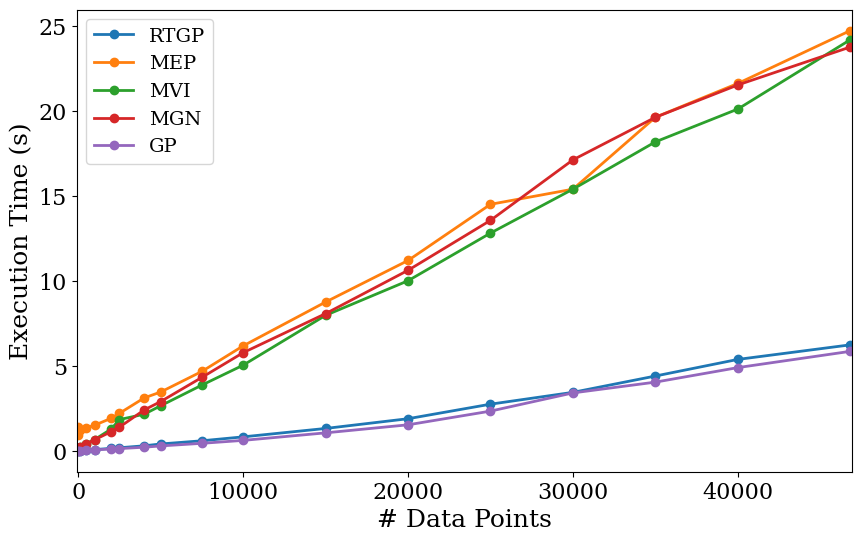

In [ ]:
df_times.set_index("n_data_pts").plot(linewidth=2,
                                    style='.-',
                                    markersize=12,
                                    figsize=(10,6),
                                    fontsize=16)
plt.xlabel("# Data Points", fontsize=18)  # X-axis label
plt.ylabel("Execution Time (s)", fontsize=18)  # Y-axis label
plt.xlim(df_times["n_data_pts"].iloc[0]-100, df_times["n_data_pts"].iloc[-1]+100)
#plt.savefig("./plots/comp-time-HFT.pdf", format='pdf', bbox_inches='tight')

In [180]:
def compute_means():

    data = pd.read_csv("../datasets/kaggle_HFT_index_futures.csv")
    true_obs = data["last_price"].to_numpy()[:1000]
    obs = true_obs.copy()
    obs_grid = (np.arange(0, len(obs)) * 0.001 * 500)[:1000]

    center_idx = 500
    outliers_idx = [center_idx + i for i in range(-4, 5, 1)]

    for i, drop in zip(outliers_idx, [0.9995, 0.9994, 0.9992, 0.996, 0.994, 0.998, 0.998, 0.9998]):
        obs[i] = obs[i]*drop
    
    

    mean = obs.mean()
    obs_std = obs.std()
    obs = (obs- mean)/obs_std
    true_obs = (true_obs - mean)/obs_std

    filter_grid, m_rtgp, P_rtgp = rtgp(obs_grid, obs)
    filter_grid, m_std_gp, P_std_gp = std_gp(obs_grid, obs)
    mu_EP, std_EP, EP_model = bayes_newton_EP(obs_grid, obs)
    mu_VI, std_VI, VI_model = bayes_newton_variational(obs_grid, obs)
    #mu_gaussnewton, std_gaussnewton, gaussnewton_model = bayes_newton_gaussnewton(obs_grid, obs)
    mu_bayesnewton, std_bayesnewton, bayesnewton_model = bayes_newton_laplaceriemann(obs_grid, obs)

    return mu_bayesnewton, mu_VI, mu_EP, m_rtgp, m_std_gp, obs_grid, true_obs

mu_bayesnewton, mu_VI, mu_EP, m_rtgp, m_std_gp, obs_grid, true_obs = compute_means()

Prediction time :  0.07796096801757812
Prediction time :  0.05063581466674805
optimisation time: 5.31 secs
Negative Log Predictive Density: 
-0.5783717897392479
Prediction time (s) :  0.753838062286377
Lengthscale :  4.828022023984271
Kernel Variance :  0.3977908402450621
optimisation time: 3.36 secs
Negative Log Predictive Density: 
-0.5897199685521641
Prediction time (s) :  0.6802608966827393
Lengthscale :  4.741261972325502
Kernel Variance :  0.4221597146277197
optimisation time: 3.22 secs
Negative Log Predictive Density: 
-0.8552899045650308
Prediction time (s) :  0.6569199562072754
Lengthscale :  3.3245014625751867
Kernel Variance :  0.4218401191714902


MVI 0.15458713348473552 0.09886595080596881
RTGP 0.14411869558444126 0.09896303909789331
MGP 0.4698318480922481 0.1389951053714654
MEP 0.14360397185102022 0.09744515488120001
MGN 0.17221187830011117 0.08322802937448577


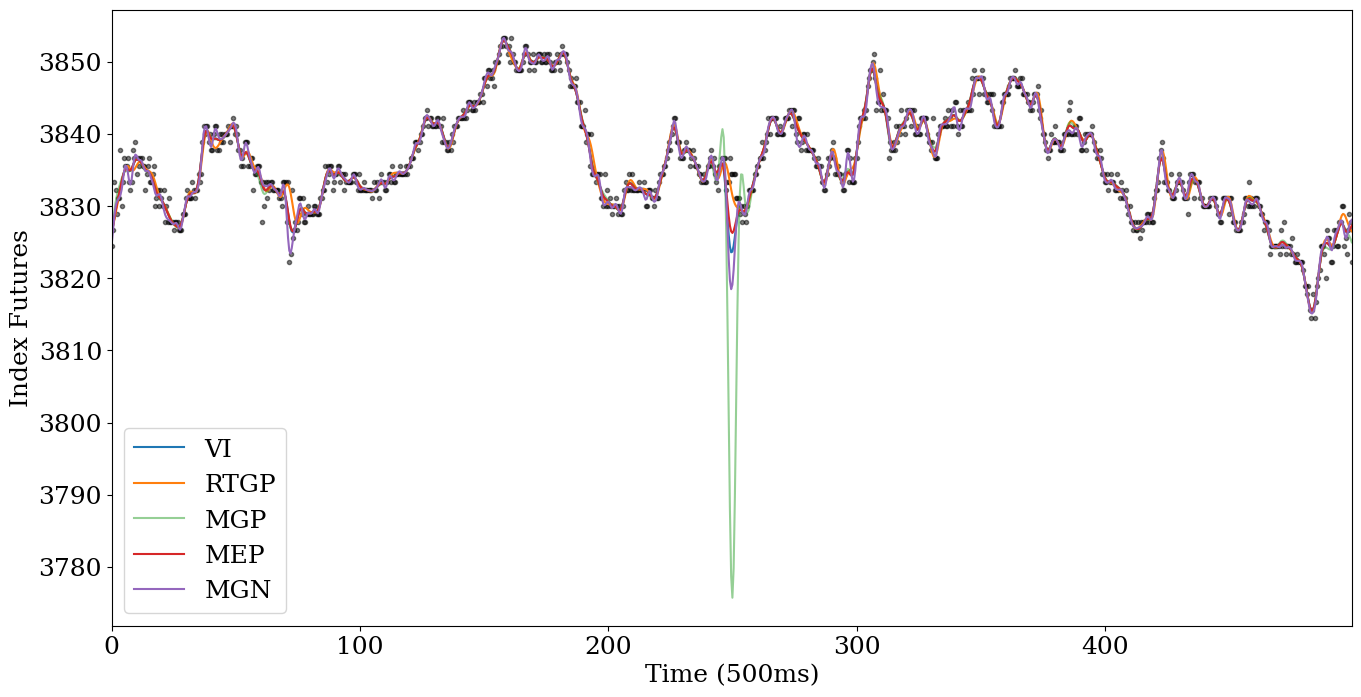

In [ ]:
plt.rc('font', family='serif', size=18)

plt.figure(figsize=(16,8))
plt.plot(obs_grid, obs_std*true_obs + mean, '.', alpha=0.5, color='black')
plt.plot(obs_grid, obs_std*mu_VI + mean, label='VI')
plt.plot(obs_grid, obs_std*m_rtgp[1:, 0].flatten() + mean, label="RTGP")
plt.plot(obs_grid, obs_std*m_std_gp[1:, 0].flatten() + mean, alpha=0.5, label="MGP")
plt.plot(obs_grid, obs_std*mu_EP + mean, label="MEP")
plt.plot(obs_grid, obs_std*mu_bayesnewton + mean, label="MGN")
plt.xlim(obs_grid[0], obs_grid[-1])
plt.legend()

print("MVI", rmse(mu_VI, true_obs), mae(mu_VI, true_obs))
print("RTGP", rmse(m_rtgp[1:, 0].flatten(), true_obs), mae(m_rtgp[1:, 0].flatten(), true_obs))
print("MGP", rmse(m_std_gp[1:, 0].flatten(), true_obs), mae(m_std_gp[1:, 0].flatten(), true_obs))
print("MEP", rmse(mu_EP, true_obs), mae(mu_EP, true_obs))
print("MGN", rmse(mu_bayesnewton, true_obs), mae(mu_bayesnewton, true_obs))

plt.ylabel("Index Futures")
plt.xlabel("Time (500ms)")

#plt.savefig("./plots/rmse-comparison-plot.pdf", format='pdf', bbox_inches='tight')

In [ ]:
.145292

In [183]:
obs_grid

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,
        27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,
        31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,
        36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,
        40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,
        45. ,  45.5,  46. ,  46.5,  47. ,  47.5,  48. ,  48.5,  49. ,
        49.5,  50. ,  50.5,  51. ,  51.5,  52. ,  52.5,  53. ,  53.5,
        54. ,  54.5,  55. ,  55.5,  56. ,  56.5,  57. ,  57.5,  58. ,
        58.5,  59. ,  59.5,  60. ,  60.5,  61. ,  61.5,  62. ,  62.5,
        63. ,  63.5,